# Extracting Window Size manually from STM image


Essentially we are looking for the maximum absolute FFT value and respective position of this value which is used to determine the atom spacing and window size. This is beacause the peak of the abs FFT gives you the periodicity of the lattice. 

## Loading Image 

In [66]:
get_ipython().magic('reset -sf') 

In [67]:
# set up notebook to show plots within the notebook
%matplotlib inline

# Import necessary libraries:
# General utilities:
import os
import sys
from time import time

# Computation:
import numpy as np
import h5py
from skimage import measure
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist 

# Visualization:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import ImageGrid

# Packages for plotting and displaying images/data
from PIL import Image
import spiepy

# Finally, pycroscopy itself
sys.path.append('../../../')
import pycroscopy as px
import pyUSID as usid
import sidpy

# Useful functions
from sidpy.viz.plot_utils import plot_map_stack
usid.plot_utils.use_nice_plot_params()

import warnings
warnings.filterwarnings("ignore")

In [68]:
# Recording default directory
default_dir = os.getcwd()

# Changing the flat file translator directory
translator_code_dir = '/Users/sulaymandesai/Documents/Year_4/MSciProject/Translator'
os.chdir(translator_code_dir)

# Importing and instantiating flat file translator class
from FlatFileTranslator import FlatFileTranslator
tran = FlatFileTranslator()

In [69]:
os.chdir(default_dir)

In [70]:
FlatFile = '/Users/sulaymandesai/Documents/Year_4/MSciProject/Analysis/prac'
h5USID = '/Users/sulaymandesai/Documents/Year_4/MSciProject/Analysis/h5usid'

In [71]:
h5Path = tran.translate(FlatFile, h5USID)

In [72]:
path = h5Path[1]

In [73]:
h5_file = h5py.File(path, mode='r+')
sidpy.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


In [74]:
# Identifying the main dataset
h5_main = usid.hdf_utils.get_all_main(h5_file)[-1] # Finds all the main data sets. 
print(h5_main)

<HDF5 dataset "Raw_Data": shape (250000, 1), type "<f8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	topo (m) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 500 
	X - size: 500 
Spectroscopic Dimensions: 
	None - size: 1
Data Type:
	float64


In [75]:
# Get the image data as a numpy array
imgArr = h5_main.get_n_dim_form().squeeze()

In [76]:
# Use SPIEpy package to plane subtract the image
imgSub = spiepy.flatten_poly_xy(imgArr, mask=None, deg=1)[0]

# Subtract out the mean of the image
imgSub = imgSub - np.mean(imgSub) 

In [77]:
imgSub_1D = imgSub.reshape((imgSub.shape[0] * imgSub.shape[1], 1))

In [78]:
h5_results_group_1 = h5_file['/Measurement_000/Channel_000']
print(h5_results_group_1)

<HDF5 group "/Measurement_000/Channel_000" (5 members)>


In [79]:
## Once run, comment out to prevent creating new dataset
h5_sub = usid.hdf_utils.write_main_dataset(h5_results_group_1,  # parent group
                                            imgSub_1D,  # data to be written
                                            'Plane_Mean_Subtracted_Data',  # Name of the main dataset
                                            'Plane and mean -Subtracted topo',  # quantity
                                            'm',  # units
                                            None,  # position dimensions
                                            None,  # spectroscopic dimensions
                                            h5_pos_inds=h5_main.h5_pos_inds,
                                            h5_pos_vals=h5_main.h5_pos_vals,
                                            h5_spec_inds=h5_main.h5_spec_inds,
                                            h5_spec_vals=h5_main.h5_spec_vals)

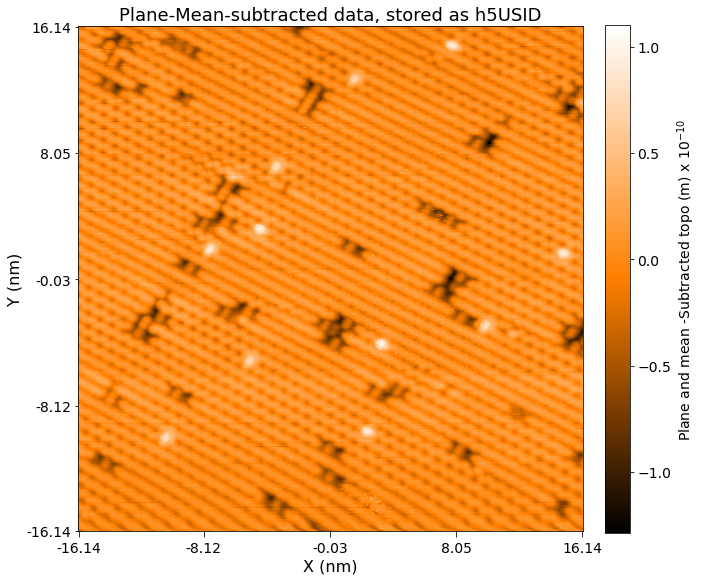

In [80]:
# Get plane and mean subtracted main data
h5Sub_main = usid.hdf_utils.get_all_main(h5_file)[0] 

# Use pyUSID to visualise the image
usid.plot_utils.use_nice_plot_params()
fig, axis = h5Sub_main.visualize(figsize=(10,10), num_ticks=5, cmap = spiepy.NANOMAP)
_ = axis.set_title('Plane-Mean-subtracted data, stored as h5USID', fontsize=18)

In [81]:
iw = px.processing.ImageWindow(h5Sub_main, max_RAM_mb=1024*4)

## Starting image window determining process

Below, I am defining a gaussian fitting functionto fit a normally distributed spectrum to the data, and a chi squared function to see the goodness of the fit.

In [82]:
def __gauss_fit(p, x):
    """
    simple gaussian fitting function
    """
    a = p[0]
    s = p[1]

    g = a * np.exp(-(x / s) ** 2)

    return g

def __gauss_chi(p, x, y):
    """
    Simple chi-squared fit
    """
    gauss = __gauss_fit(p, x)

    chi2 = ((y - gauss) / y) ** 2

    return chi2

In [83]:
h5Main = h5Sub_main.get_n_dim_form().squeeze()

In [84]:
h5Main.shape

(500, 500)

Below I am just normalising the image to bring centre the values within a normalised range

In [182]:
# Normalize the image

immin = np.min(h5Main)
immax = np.max(h5Main)
        
image = np.float32(h5Main - immin) / (immax - immin)

In [183]:
immin

-1.288597339418131e-10

In [184]:
immax

1.1047912402017934e-10

## Performing FFT on image

In signal processing and statistics, a window function (also known as an apodization function or tapering function[1]) is a mathematical function that is zero-valued outside of some chosen interval, normally symmetric around the middle of the interval, usually near a maximum in the middle, and usually tapering away from the middle. Mathematically, when another function or waveform/data-sequence is "multiplied" by a window function, the product is also zero-valued outside the interval: all that is left is the part where they overlap, the "view through the window". Equivalently, and in actual practice, the segment of data within the window is first isolated, and then only that data is multiplied by the window function values. Thus, tapering, not segmentation, is the main purpose of window functions. A hamming window is just a type of multiplication for the isolated data. 

https://en.wikipedia.org/wiki/Window_function

Discrete Fourier transform is what you need to do when you have a digitised signal.  You can write down the Fourier transform of some function analytically.  But when instead of a function you have a discrete series of data points, then you must do a discrete  Fourier transform.  But you can think of it just as a Fourier transform of the data essentially.  The Fast Fourier transform is just a particularly efficient algorithm for computing the discrete Fourier transform if I remember correctly.  There can be a lot of subtlety to this and I’m not sure whether we need to go into it in more detail than that or not. 

I think you understand the basics of the Fourier transform itself - It’s basically if you decompose some waveform into a ideal sin waves then the Fourier transform is telling you the amplitudes of the individual sin waves that go into making up the original signal.  Again, it is more subtle than that, but that’s the gist of it.  For images we do a Fourier transform in 2D.  So, if the image were a hexagonal array of atoms, then we expect to find the fourier transform is a set of hexagon spots located at the frequencies corresponding to the atomic spacings.  

In [110]:
im_shape = np.min(image.shape)

# A hamming filter is a
def __hamming(data):
    """
    Simple hamming filter
    """
    u, v = np.shape(data)
    u_vec = np.linspace(0, 1, u)
    v_vec = np.linspace(0, 1, v)
    u_mat, v_mat = np.meshgrid(u_vec, v_vec, indexing='ij')
    h_filter = np.multiply((1 - np.cos(2 * np.pi * u_mat)), (1 - np.cos(2 * np.pi * v_mat))) / 4.0

    return np.multiply(data, h_filter)

We apply a hamming window to reduce spectral leakage by reducing the amplitude of the data as it reaches the edges, as seen in the figure below. This removes any spectral discontinuties from the FFT. 2D FFT has peaks at spatial frequencies of repeated texture (i.e. atom positions). DFT assumes that input signal is one period of a periodic signal and outputs discrete frequencies of this periodic signal. Hamming window reduces noise and helps push through a more periodic signal.

In [185]:
# Centering, subtracting the mean from the image
im2 = image - np.mean(image)

# Computing 2 dimensional discrete fourier transform and shifting so the 0 frequency component is at the centre
fim = np.fft.fftshift(np.fft.fft2(__hamming(im2)))

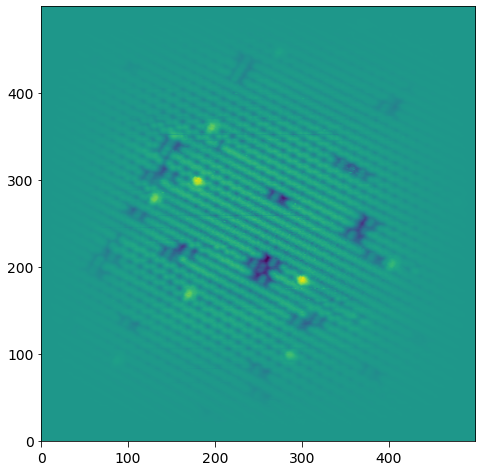

In [186]:
plt.figure(figsize = (8,8))
plt.imshow(__hamming(im2), origin = 'lower')

Just testing without hamming window.

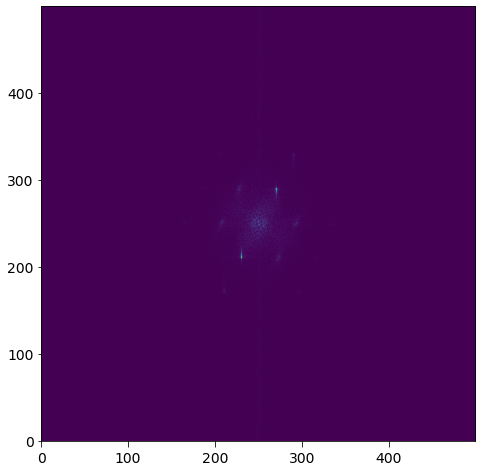

In [113]:
prac = np.fft.fftshift(np.fft.fft2(im2))

# Getting absolute values of image FFT
pracabs = np.abs(prac)

plt.figure(figsize = (8,8))
plt.imshow(pracabs, origin = 'lower')
# plt.savefig('abs1.png')

Defining meshgrids are useful for future calculations, especially as we're dealing with large arrays which we are going to iterate over.

In [187]:
imrange = np.arange(-im_shape / 2, im_shape / 2)

uu, vv = np.meshgrid(imrange, imrange)

In [188]:
imrange

array([-250., -249., -248., -247., -246., -245., -244., -243., -242.,
       -241., -240., -239., -238., -237., -236., -235., -234., -233.,
       -232., -231., -230., -229., -228., -227., -226., -225., -224.,
       -223., -222., -221., -220., -219., -218., -217., -216., -215.,
       -214., -213., -212., -211., -210., -209., -208., -207., -206.,
       -205., -204., -203., -202., -201., -200., -199., -198., -197.,
       -196., -195., -194., -193., -192., -191., -190., -189., -188.,
       -187., -186., -185., -184., -183., -182., -181., -180., -179.,
       -178., -177., -176., -175., -174., -173., -172., -171., -170.,
       -169., -168., -167., -166., -165., -164., -163., -162., -161.,
       -160., -159., -158., -157., -156., -155., -154., -153., -152.,
       -151., -150., -149., -148., -147., -146., -145., -144., -143.,
       -142., -141., -140., -139., -138., -137., -136., -135., -134.,
       -133., -132., -131., -130., -129., -128., -127., -126., -125.,
       -124., -123.,

In [189]:
uu

array([[-250., -249., -248., ...,  247.,  248.,  249.],
       [-250., -249., -248., ...,  247.,  248.,  249.],
       [-250., -249., -248., ...,  247.,  248.,  249.],
       ...,
       [-250., -249., -248., ...,  247.,  248.,  249.],
       [-250., -249., -248., ...,  247.,  248.,  249.],
       [-250., -249., -248., ...,  247.,  248.,  249.]])

In [190]:
vv

array([[-250., -250., -250., ..., -250., -250., -250.],
       [-249., -249., -249., ..., -249., -249., -249.],
       [-248., -248., -248., ..., -248., -248., -248.],
       ...,
       [ 247.,  247.,  247., ...,  247.,  247.,  247.],
       [ 248.,  248.,  248., ...,  248.,  248.,  248.],
       [ 249.,  249.,  249., ...,  249.,  249.,  249.]])

## Finding maximum at each radial distance from the centre

Now we are going to go through the absolute FFT values and grab some of the maximum values. We grab roughly 125 values as we do not need to determine 500 values from the whole image as image is periodic. I believe we are treating the image as 4 unit cells and we focus on the length of 1 unit cell for our analysis.

In [191]:
# Why am I dividing by 4? Possibly as you want window size to be at least 4x4 unit cells
r_n = int(im_shape / 4)

# Specifying the radius of the image?
r_min = 0
r_max = im_shape / 2

# Creating a vector of 125 values till radius of image. Why is it transposed?
r_vec = np.linspace(r_min, r_max, r_n, dtype=np.float32).transpose()

r_vec is an array of values which contain positions over which we will grab the max values. Spaced by 2, which is small enough.

In [192]:
# Useful for calculations later
r_mat = np.abs(uu + 1j * vv)

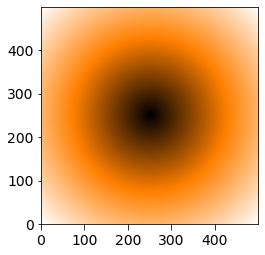

In [193]:
plt.imshow(r_mat, origin = 'lower', cmap = spiepy.NANOMAP)

Converting from complex to real FFT values.

In [194]:
# Getting absolute values of image FFT
fimabs = np.abs(fim)
fimabs_max = np.zeros(r_n - 1)

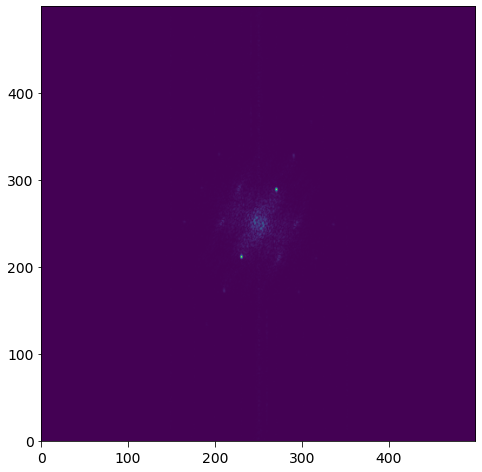

In [195]:
plt.figure(figsize = (8,8))
plt.imshow(fimabs, origin = 'lower')
# plt.savefig('abs2.png')

Comparing non-hamming window FFt with hamming window FFt.

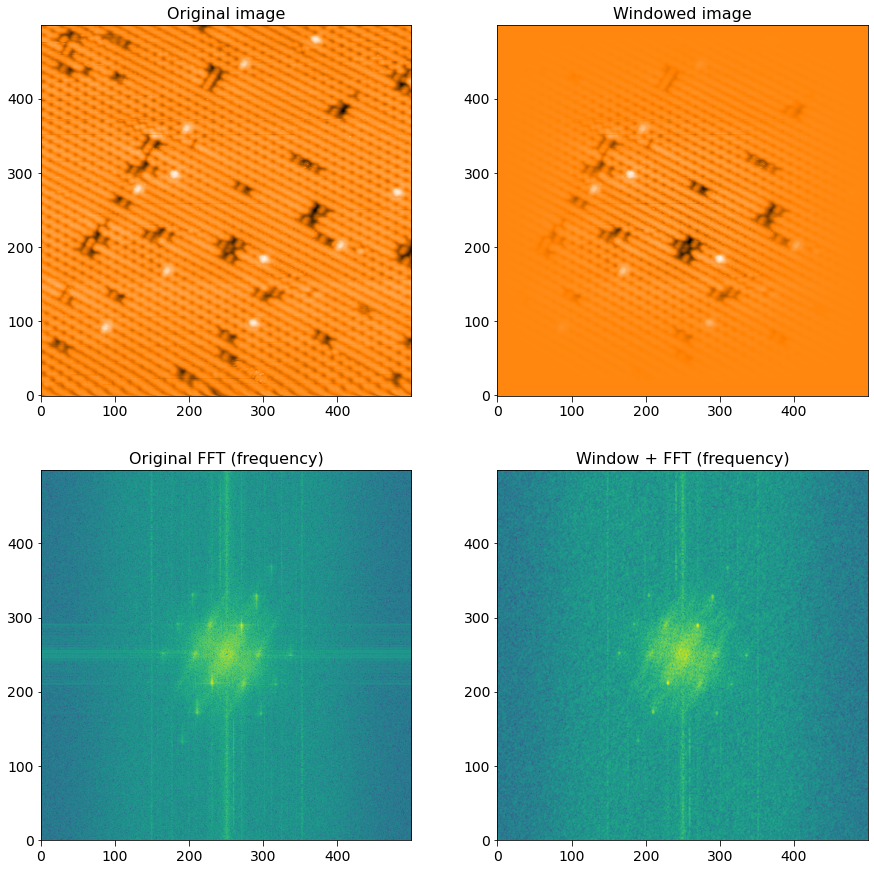

In [126]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
ax = axes.ravel()
ax[0].set_title("Original image")
ax[0].imshow(im2, cmap=spiepy.NANOMAP, origin = 'lower')
ax[1].set_title("Windowed image")
ax[1].imshow(__hamming(im2), cmap=spiepy.NANOMAP, origin = 'lower')
ax[2].set_title("Original FFT (frequency)")
ax[2].imshow(np.log(pracabs), origin = 'lower')
# ax[2].imshow(pracabs, origin = 'lower')
ax[3].set_title("Window + FFT (frequency)")
ax[3].imshow(np.log(fimabs), origin = 'lower')
# ax[3].imshow(fimabs, origin = 'lower')
# plt.savefig('HammingFFTLogPlot.png')
plt.show()


Below code is essentially going through the absolute FFT values 124 times and grabbing the max values from each. r_ind keeps getting larger and larger so we can go through more values. Essentially is grows with k. We find the maximum values for absolute FFT and store this in an array.

In [196]:
# Looking for max values along axis. Assuming looking for max intensities / z-heights for where atoms are
for k in range(r_n - 1):
    r1 = r_vec[k]
    r2 = r_vec[k + 1]
    r_ind = np.where(np.logical_and(r_mat >= r1, r_mat <= r2))
    fimabs_max[k] = np.max(fimabs[r_ind])

In [197]:
fimabs_max

array([ 458.44267244,  517.69994993,  476.56265894,  532.4887711 ,
        314.66572039,  219.49107166,  281.65300472,  177.95374248,
        199.50822042,  184.1310984 ,  165.90925789,  138.83687578,
        140.72132892,  130.10074677,  148.9962942 ,  113.74231361,
        130.28700367,   80.38806021,   85.20994092,  132.73438307,
        530.61104641, 1604.31041737,  868.7447777 ,  156.81005955,
        102.55263468,   56.39885207,   34.49462829,   37.28815503,
         25.04311474,   29.61094816,   31.44983411,   22.66712871,
         40.96383752,   24.46664966,   22.2883928 ,   19.18118396,
         26.315847  ,   45.55839596,   40.0890178 ,   23.95066877,
         31.36763363,   40.10155322,   91.83804915,  156.15984351,
         63.64014418,   47.82012817,   21.35970501,    9.44421635,
         18.01249508,   12.87334974,   17.84889777,   23.40943697,
         20.80898983,   36.72429119,   20.84331104,   18.19251515,
         14.46114486,   24.3336135 ,   23.58089747,   22.10562

Think below is just shifting values to remove zero values.

In [198]:
r_vec = r_vec[:-1] + (r_max - r_min) / (r_n - 1.0) / 2.0

In [199]:
r_vec

array([  1.0080645,   3.0241935,   5.0403223,   7.056452 ,   9.07258  ,
        11.08871  ,  13.104838 ,  15.120968 ,  17.137096 ,  19.153225 ,
        21.169355 ,  23.185484 ,  25.201612 ,  27.217741 ,  29.233871 ,
        31.25     ,  33.26613  ,  35.282257 ,  37.298386 ,  39.314514 ,
        41.330647 ,  43.346775 ,  45.362904 ,  47.379032 ,  49.39516  ,
        51.41129  ,  53.427418 ,  55.443546 ,  57.45968  ,  59.475807 ,
        61.491936 ,  63.508064 ,  65.52419  ,  67.54032  ,  69.55645  ,
        71.57258  ,  73.58871  ,  75.604836 ,  77.620964 ,  79.6371   ,
        81.65323  ,  83.66936  ,  85.685486 ,  87.701614 ,  89.71774  ,
        91.73387  ,  93.75     ,  95.76613  ,  97.78226  ,  99.798386 ,
       101.814514 , 103.83064  , 105.84677  , 107.8629   , 109.87903  ,
       111.895164 , 113.91129  , 115.92742  , 117.94355  , 119.95968  ,
       121.97581  , 123.991936 , 126.008064 , 128.0242   , 130.04033  ,
       132.05646  , 134.07259  , 136.08871  , 138.10484  , 140.1

## Finding local maxima

Below code is grabbing the index for when value of absolute FFT is larger than its neighbours which finds the local maximum indexes.

In [200]:
# Finding index for local maxima
count = 0
local_max = []
for k in range(1, fimabs_max.size - 1):
    if fimabs_max[k - 1] < fimabs_max[k] and fimabs_max[k] > fimabs_max[k + 1]:
        count += 1
        local_max.append(k)

In [201]:
local_max

[1,
 3,
 6,
 8,
 12,
 14,
 16,
 21,
 27,
 30,
 32,
 37,
 43,
 48,
 51,
 53,
 57,
 61,
 66,
 69,
 71,
 74,
 77,
 83,
 85,
 87,
 89,
 91,
 95,
 99,
 101,
 104,
 106,
 108,
 112,
 120]

Grabbing position and abs fft values from index above

In [202]:
# Getting points correspondong to local maxima
r_loc_max_vec = r_vec[local_max]
fimabs_loc_max_vec = fimabs_max[local_max]

In [203]:
print(r_loc_max_vec)
print(fimabs_loc_max_vec)

[  3.0241935   7.056452   13.104838   17.137096   25.201612   29.233871
  33.26613    43.346775   55.443546   61.491936   65.52419    75.604836
  87.701614   97.78226   103.83064   107.8629    115.92742   123.991936
 134.07259   140.12097   144.15323   150.20161   156.25      168.34679
 172.37904   176.4113    180.44356   184.47581   192.54033   200.60484
 204.6371    210.68549   214.71774   218.75      226.81453   242.94356  ]
[ 517.69994993  532.4887711   281.65300472  199.50822042  140.72132892
  148.9962942   130.28700367 1604.31041737   37.28815503   31.44983411
   40.96383752   45.55839596  156.15984351   18.01249508   23.40943697
   36.72429119   24.3336135    30.02747263   26.87574941   37.15078529
   26.01622048   26.74103971   20.18647332   26.17363069   30.82230478
   17.00842398   20.685911     18.39441939   32.08434409   21.1151329
   31.06680701   36.34041104   19.23283697   23.27672187   28.90904753
   22.13812718]


Finding the largest FFT value and removing any positions before this peak.

In [204]:
# Removing points below radius of tallest peak 


# Index for local fourier maxima
fimabs_loc_max_ind = np.argmax(fimabs_loc_max_vec)
print(fimabs_loc_max_ind)

7


In [205]:
# Retrieving vector for local max
fimabs_loc_max_vec = fimabs_loc_max_vec[fimabs_loc_max_ind:]
print(fimabs_loc_max_vec)
r_loc_max_vec = r_loc_max_vec[fimabs_loc_max_ind:]
print(r_loc_max_vec)

[1604.31041737   37.28815503   31.44983411   40.96383752   45.55839596
  156.15984351   18.01249508   23.40943697   36.72429119   24.3336135
   30.02747263   26.87574941   37.15078529   26.01622048   26.74103971
   20.18647332   26.17363069   30.82230478   17.00842398   20.685911
   18.39441939   32.08434409   21.1151329    31.06680701   36.34041104
   19.23283697   23.27672187   28.90904753   22.13812718]
[ 43.346775  55.443546  61.491936  65.52419   75.604836  87.701614
  97.78226  103.83064  107.8629   115.92742  123.991936 134.07259
 140.12097  144.15323  150.20161  156.25     168.34679  172.37904
 176.4113   180.44356  184.47581  192.54033  200.60484  204.6371
 210.68549  214.71774  218.75     226.81453  242.94356 ]


Sorting the peak from largest abs fft values to smallest. Now we have the position of the largest peak associated with each other.

In [207]:
# Sorting peaks from largest to smallest
sort_ind = np.argsort(fimabs_loc_max_vec)[::-1]
print(sort_ind)
fimabs_sort = fimabs_loc_max_vec[sort_ind]
print(fimabs_sort)
r_sort = r_loc_max_vec[sort_ind]
print(r_sort)

[ 0  5  4  3  1 12  8 24 21  2 23 17 10 27 11 14 16 13  9  7 26 28 22 19
 15 25 20  6 18]
[1604.31041737  156.15984351   45.55839596   40.96383752   37.28815503
   37.15078529   36.72429119   36.34041104   32.08434409   31.44983411
   31.06680701   30.82230478   30.02747263   28.90904753   26.87574941
   26.74103971   26.17363069   26.01622048   24.3336135    23.40943697
   23.27672187   22.13812718   21.1151329    20.685911     20.18647332
   19.23283697   18.39441939   18.01249508   17.00842398]
[ 43.346775  87.701614  75.604836  65.52419   55.443546 140.12097
 107.8629   210.68549  192.54033   61.491936 204.6371   172.37904
 123.991936 226.81453  134.07259  150.20161  168.34679  144.15323
 115.92742  103.83064  218.75     242.94356  200.60484  180.44356
 156.25     214.71774  184.47581   97.78226  176.4113  ]


Specifying no. of peaks want to be used.

In [208]:
# We specify no. of peaks, can guess but skipped out as not using
num_peaks = 2

fimabs_sort = fimabs_sort[:num_peaks]
print(fimabs_sort)
r_sort = r_sort[:num_peaks]
print(r_sort)

[1604.31041737  156.15984351]
[43.346775 87.701614]


Fitting gaussian to number of peaks

In [209]:
# Fitting to gaussian

from scipy.optimize import leastsq


# Why do we multiply by 2?
gauss_guess = (2 * np.max(fimabs_sort), r_sort[0])
print(gauss_guess)

# least square chi squared fit
fit_vec, pcov, info, errmsg, success = leastsq(__gauss_chi,
                                               gauss_guess,
                                               args=(r_sort, fimabs_sort),
                                               full_output=1,
                                               maxfev=250)

(3208.620834738868, 43.346775)


In [210]:
print(fit_vec)
print(pcov)

[3208.62083474   43.34677505]
None


## Determing pixel size of atom and window size

Now we use the position of the largest abs fft value to determine the atomic spacing and the appropriate window size with a few simple calculations.

In [211]:
# pixel width. Absolute length of image (500), divided by radial distance between atoms and dividing by pi 
psf_width = im_shape / fit_vec[1] / np.pi
psf_width

3.6716674513895122

In [212]:
r_sort[0]+ 0.5

43.84677505493164

In [213]:
# Image window pixel size
# window_size = im_shape / (r_sort[0] + 0.5)
window_size = im_shape / (r_sort[0] + 0.5)
window_size

11.403347210224593

In [214]:
# limits the values in array between certain interval
window_size = np.clip(window_size, 1, int(im_shape / 6.0))
window_size

11.403347210224593

In [215]:
window_size = np.int(np.round(window_size * 2))
window_size

23

In [216]:
psf_width

3.6716674513895122

As we can see in the below graph, a gaussian is fitted to 2 of the abs FFT peaks which shows us the 2 peaks and their respective positions. Using this data we determine the window size.

Peaks in the profile give frequencies of sepearation of the atoms in STM image. Separation given in reciprocal space. So we find values and calculate inverse. We fit gaussian to obtain exact peak position. Taking the reciprocal of this value gives the separation of the atoms in the image.

Determining appropriate window size from image.


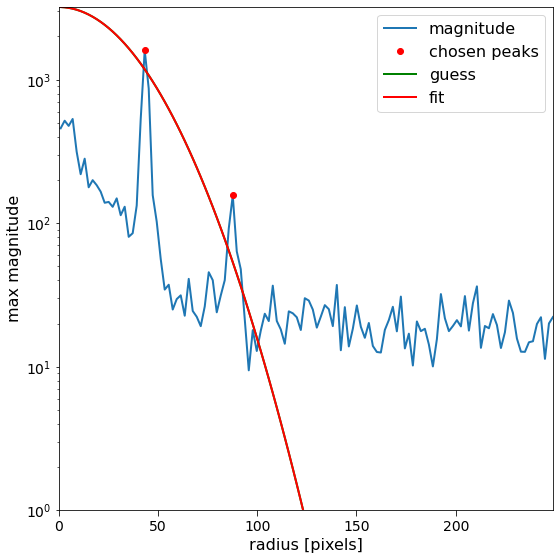

Window size = 23


In [219]:
num_peaks = 2
win_size , psf_width = iw.window_size_extract(num_peaks, save_plots=False, show_plots=True)

print('Window size = {}'.format(win_size))

In [220]:
help(iw.window_size_extract)

Help on method window_size_extract in module pycroscopy.processing.image_processing:

window_size_extract(num_peaks=2, save_plots=True, show_plots=False) method of pycroscopy.processing.image_processing.ImageWindow instance
    Take the normalized image and extract from it an optimal window size
    
    Parameters
    ----------
    num_peaks : int, optional
        number of peaks to use during least squares fit
        Default 2
    save_plots : Boolean, optional
        If True then a plot showing the quality of the fit will be
        generated and saved to disk.  Ignored if do_fit is false.
        Default True
    show_plots : Boolean, optional
        If True then a plot showing the quality of the fit will be
        generated and shown on screen.  Ignored if do_fit is false.
        Default False
    
    Returns
    -------
    window_size : int
        Optimal window size in pixels
    psf_width : int
        Estimate atom spacing in pixels



Both window_size and psf_width determined the same as standard function. 

In [221]:
def __plot_window_fit(self, r_vec, r_sort, fft_absimage, fft_abssort, guess, fit,
                      save_plots=True, show_plots=False):
    """
    Generate a plot showing the quality of the least-squares fit to the peaks of the FFT of the image

    Parameters
    ----------
    r_vec : numpy array
        1D array of unsorted radii in pixels
    r_sort : numpy array
        1D array of the sorted radii
    fft_absimage : numpy array
        1D array of the absolute value of the FFT of the normalized image
    fft_abssort : numpy array
        1D array of FFT_absimage after being sorted to match r_sort
    guess :  numpy array
        1D array of the gaussian guess
    fit : numpy array
        1D array of the fitted gaussian
    save_plots : Boolean, optional
        If True then a plot showing the quality of the fit will be
        generated and saved to disk.
        Default True
    show_plots : Boolean, optional
        If True then a plot showing the quality of the fit will be
        generated and shown on screen.
        Default False

    Returns
    -------
    None

    """

    fig = plt.figure(figsize=[8, 8], tight_layout=True)
    plt1, = plt.semilogy(r_vec, fft_absimage, label='magnitude')
    plt2, = plt.semilogy(r_sort, fft_abssort, 'ro', label='chosen peaks')
    plt3, = plt.semilogy(r_vec, guess, 'g', label='guess')
    plt4, = plt.semilogy(r_vec, fit, 'r', label='fit')
    ax = fig.gca()
    ax.autoscale(tight=True)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=1)
    ax.set_xlabel('radius [pixels]')
    ax.set_ylabel('max magnitude')
    plt.legend(handles=[plt1, plt2, plt3, plt4])

    if save_plots:
        folder, filename = os.path.split(self.hdf.path)
        basename, junk = os.path.splitext(filename)

        plotname = '_'.join([basename, 'window_fit'])
        plotpath = os.path.join(folder, plotname + '.png')

        fig.savefig(plotpath, format='png')

    if show_plots:
        plt.show()

In [222]:
help(__plot_window_fit)

Help on function __plot_window_fit in module __main__:

__plot_window_fit(self, r_vec, r_sort, fft_absimage, fft_abssort, guess, fit, save_plots=True, show_plots=False)
    Generate a plot showing the quality of the least-squares fit to the peaks of the FFT of the image
    
    Parameters
    ----------
    r_vec : numpy array
        1D array of unsorted radii in pixels
    r_sort : numpy array
        1D array of the sorted radii
    fft_absimage : numpy array
        1D array of the absolute value of the FFT of the normalized image
    fft_abssort : numpy array
        1D array of FFT_absimage after being sorted to match r_sort
    guess :  numpy array
        1D array of the gaussian guess
    fit : numpy array
        1D array of the fitted gaussian
    save_plots : Boolean, optional
        If True then a plot showing the quality of the fit will be
        generated and saved to disk.
        Default True
    show_plots : Boolean, optional
        If True then a plot showing the